In [ ]:
import torch ,  torchvision
from torchvision import transforms , datasets , models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from matplotlib import image as img
import glob
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset , DataLoader , SubsetRandomSampler as srs
import torchvision.transforms.functional as TF
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# https://drive.google.com/file/d/1la3oe-J3aioosw3cqe7T44kW7QxcgnjT/view?usp=sharing    trained model file
# https://drive.google.com/drive/folders/18XlIxPsVACa9lyrARwiLv8JnsfuTR2CM?usp=sharing    dataset files
#https://drive.google.com/drive/folders/1OpFZSigxAJbJXfYWrIh19N-XmJ6SBH4D?usp=sharing   3rd dataset

#https://drive.google.com/file/d/1UpvEt6VIJuMBNcwPRmMrYqNGZE95Uz8p/view?usp=sharing     more accurate model


In [ ]:
root = "/content/drive/MyDrive/archive (4)"   #edit to where the folder is located

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
path = root + "/images/Cars3.png"

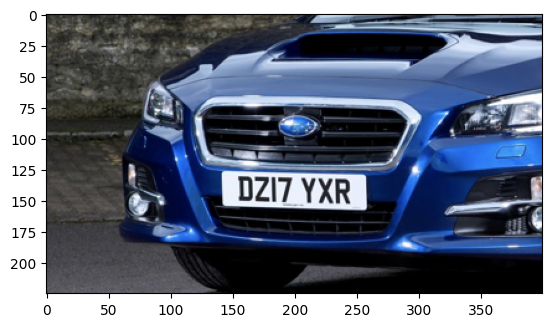

In [ ]:
image = img.imread(path)
plt.imshow(image)
plt.show()

In [ ]:
path = root + "/number-plate-detection/images/N100.jpeg"

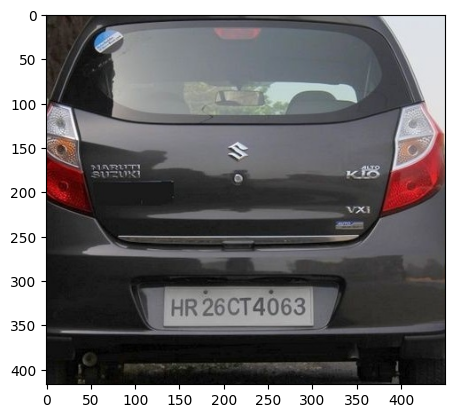

In [ ]:
image = img.imread(path)
plt.imshow(image)
plt.show()

In [ ]:
class cardataset1(Dataset):
    def __init__(self):
        self.annotation_list = sorted([file for file in glob.glob(root + "/annotations/*.xml")])



        self.image = [cv2.imread(file) for file in sorted(glob.glob(root + "/images/*.png") )]

        self.root = root
        self.transforms = transforms.Compose([transforms.ToTensor() , transforms.Resize((512 ,512)) , transforms.Normalize([0.5,0.5,0.5] , [0.5,0.5,0.5])
                                              ])

        self.trans = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image)

    def __getitem__(self ,index):
        img = self.image[index]
        img = self.transforms(img)

        target_size = (512, 512)


        image = self.image[index]
        image = self.trans(image)    # this line used in relation to get the corect bounding box after resizing image

        annotation = os.path.join(self.annotation_list[index])#(self.root , "annotations" , self.annotation_list[index])
        annotation  = ET.parse(annotation)

        box = []

        xml_root =  annotation .getroot()
        for obj in xml_root.iter("object"):
            xml_bbox = obj.find("bndbox")
            x_min =  float(xml_bbox.find("xmin").text)
            y_min =  float(xml_bbox.find("ymin").text)
            x_max =  float(xml_bbox.find("xmax").text)
            y_max =  float(xml_bbox.find("ymax").text)


            scale_factor_width  = target_size[1] / image.shape[2]  # width scale factor
            scale_factor_height = target_size[0] / image.shape[1]

            normalized_x_min = x_min * scale_factor_width
            normalized_y_min = y_min * scale_factor_height
            xx = x_max - x_min
            xxx = xx * scale_factor_width
            normalized_x_max = xxx + normalized_x_min
            yy = y_max - y_min
            yyy  = yy * scale_factor_height
            normalized_y_max = yyy  + normalized_y_min


            bbox = [normalized_x_min,
                   normalized_y_min,
                   normalized_x_max,
                   normalized_y_max,
                  ]

            #box.append(bbox)
            box = torch.tensor(bbox)
            label = 1

            ###yolo annotation
            x_center = (normalized_x_min + normalized_x_max) / 2
            y_center = (normalized_y_min + normalized_y_max) / 2

            width = normalized_x_max - normalized_x_min
            height = normalized_y_max - normalized_y_min

            yolo_x_center = x_center / 512
            yolo_y_center = y_center / 512

            yolo_width = width / 512
            yolo_height = height / 512

            yolo_annotation = [label , yolo_x_center , yolo_y_center , yolo_width , yolo_height]

        sample = [img , bbox , torch.tensor(label)]
        return sample



In [ ]:
dataset1 = cardataset1()

In [ ]:
class cardataset2(Dataset):
    def __init__(self):
        self.annotation_list = sorted([file for file in glob.glob(root + "/number-plate-detection/images/*.xml")])



        self.image = [cv2.imread(file) for file in  glob.glob(root + "/number-plate-detection/images/*.jpeg" )]


        self.transforms = transforms.Compose([transforms.ToTensor()  ,transforms.Normalize([0.5,0.5,0.5] , [0.7,0.7,0.5]), transforms.Resize((512,512)) ])


        self.trans = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image)

    def __getitem__(self ,index):
        img = self.image[index]
        img = self.transforms(img)

        target_size = (512,512)


        image = self.image[index]
        image = self.trans(image)    #this transform only transforms to tensor, this line used in relation to get the corect bounding box after resizing image

        annotation = os.path.join(self.annotation_list[index])#(self.root , "annotations" , self.annotation_list[index])
        annotation  = ET.parse(annotation)

        box = []

        xml_root =  annotation .getroot()
        for obj in xml_root.iter("object"):
            xml_bbox = obj.find("bndbox")
            x_min =  float(xml_bbox.find("xmin").text)
            y_min =  float(xml_bbox.find("ymin").text)
            x_max =  float(xml_bbox.find("xmax").text)
            y_max =  float(xml_bbox.find("ymax").text)


            scale_factor_width  = target_size[1] / image.shape[2]  # width scale factor
            scale_factor_height = target_size[0] / image.shape[1]

            normalized_x_min = x_min * scale_factor_width
            normalized_y_min = y_min * scale_factor_height
            xx = x_max - x_min
            xxx = xx * scale_factor_width
            normalized_x_max = xxx + normalized_x_min
            yy = y_max - y_min
            yyy  = yy * scale_factor_height
            normalized_y_max = yyy  + normalized_y_min


            bbox = [normalized_x_min,
                   normalized_y_min,
                   normalized_x_max,
                   normalized_y_max,
                  ]

            #box.append(bbox)
            box = torch.tensor(bbox)
            label = 1
            ###yolo annotation
            x_center = (normalized_x_min + normalized_x_max) / 2
            y_center = (normalized_y_min + normalized_y_max) / 2

            width = normalized_x_max - normalized_x_min
            height = normalized_y_max - normalized_y_min

            yolo_x_center = x_center / 512
            yolo_y_center = y_center / 512

            yolo_width = width / 512
            yolo_height = height / 512

            yolo_annotation = [label , yolo_x_center , yolo_y_center , yolo_width , yolo_height]

        sample = [img , bbox , torch.tensor(label)]
        return sample



In [ ]:
dataset2 = cardataset2()

In [ ]:
print(len(dataset1))
print(len(dataset2))

433
225


In [ ]:
from pathlib import Path

In [ ]:
x = sorted([file for file in Path("/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX").glob("**/*.xml")])

In [ ]:
x[548]

PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/UK/UK4.xml')

In [ ]:
x = [file for file in sorted(Path("/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX").glob("**/*.jpg"))]
print(x[1])

for paths in x:
  paths = str(paths)
  paths = paths.split(".jpg")
  print(paths[0] +".xml")

/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN10.jpg
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN1.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN10.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN2.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN4.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN5.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN6.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN7.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP1.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP10.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP12.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP13.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP14.xml
/content/drive/MyDrive/indian-vehicle-dataset/State-wise_O

In [ ]:
class cardataset3(Dataset):
    def __init__(self):

        self.annotation_list = []

        self.image = [cv2.imread(str(file)) for file in sorted(Path("/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX").glob("**/*.jpg"))]

        file = [file for file in sorted(Path("/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX").glob("**/*.jpg"))]
        for paths in file:
            paths = str(paths)
            paths = paths.split(".jpg")
            xml_path = paths[0] +".xml"
            self.annotation_list.append(xml_path)

        self.transforms = transforms.Compose([transforms.ToTensor()  ,transforms.Normalize([0.5,0.5,0.5] , [0.7,0.7,0.5]) , transforms.Resize((512,512)) ])


        self.trans = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image)

    def __getitem__(self ,index):
        img = self.image[index]
        img = self.transforms(img)

        target_size = (512,512)


        image = self.image[index]
        image = self.trans(image)    #this transform only transforms to tensor, this line used in relation to get the corect bounding box after resizing image

        annotation_path = os.path.join(self.annotation_list[index])#(self.root , "annotations" , self.annotation_list[index])
        annotation  = ET.parse(annotation_path)

        box = []

        xml_root =  annotation .getroot()
        for obj in xml_root.iter("object"):
            xml_bbox = obj.find("bndbox")
            x_min =  float(xml_bbox.find("xmin").text)
            y_min =  float(xml_bbox.find("ymin").text)
            x_max =  float(xml_bbox.find("xmax").text)
            y_max =  float(xml_bbox.find("ymax").text)

            original_bbox = [x_min , y_min , x_max , y_max]

            scale_factor_width  = target_size[1] / image.shape[2]  # width scale factor
            scale_factor_height = target_size[0] / image.shape[1]

            normalized_x_min = x_min * scale_factor_width
            normalized_y_min = y_min * scale_factor_height
            xx = x_max - x_min
            xxx = xx * scale_factor_width
            normalized_x_max = xxx + normalized_x_min
            yy = y_max - y_min
            yyy  = yy * scale_factor_height
            normalized_y_max = yyy  + normalized_y_min


            bbox = [normalized_x_min,
                   normalized_y_min,
                   normalized_x_max,
                   normalized_y_max,
                  ]

            #box.append(bbox)
            box = torch.tensor(bbox)
            label = 1
            ###yolo annotation
            x_center = (normalized_x_min + normalized_x_max) / 2
            y_center = (normalized_y_min + normalized_y_max) / 2

            width = normalized_x_max - normalized_x_min
            height = normalized_y_max - normalized_y_min

            yolo_x_center = x_center / 512
            yolo_y_center = y_center / 512

            yolo_width = width / 512
            yolo_height = height / 512

            yolo_annotation = [label , yolo_x_center , yolo_y_center , yolo_width , yolo_height]

        sample = [img , bbox , torch.tensor(label)]
        return sample



In [ ]:
dataset3 = cardataset3()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


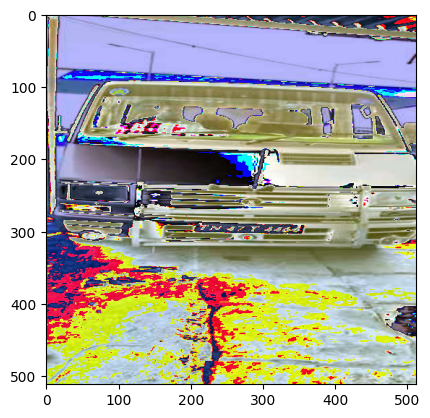

[PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN1.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN10.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN2.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN4.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN5.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN6.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AN/AN7.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP1.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP10.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP12.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-dataset/State-wise_OLX/AP/AP13.jpg'), PosixPath('/content/drive/MyDrive/indian-vehicle-

[203.2941176470588, 288.1056105610561, 357.6470588235294, 304.15841584158414]

In [ ]:
img , target , label = dataset3[512]
imgpic = TF.to_pil_image(img)
plt.imshow(imgpic)

plt.show()
target

In [ ]:
class combineddataset(Dataset):
  def __init__(self , dataset1 , dataset2 , dataset3):
    self.dataset1 = dataset1
    self.dataset2 = dataset2
    self.dataset3 = dataset3

    self.length = len(self.dataset1)+ len(self.dataset2) + len(self.dataset3)

  def __len__(self):
    return self.length

  def __getitem__(self , idx):
    if idx < len(self.dataset1):
      img , target ,label = self.dataset1[idx]
      return img ,target , label

    elif idx > len(self.dataset1) and idx < len(self.dataset1 + self.dataset2):
      idx = idx - len(self.dataset1)
      img2 , target2  , label2= self.dataset2[idx]
      return img2 , target2 , label2

    else:
      idx = idx - len(self.dataset1 + self.dataset2)
      img3 , target3 , label3= self.dataset3[idx]
      return img3 , target3 , label3




In [ ]:
dataset = combineddataset(dataset1 , dataset2 , dataset3)

In [ ]:
len(dataset)

1260

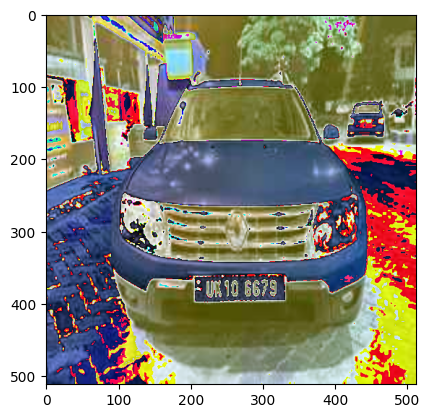

[203.2941176470588, 361.4117647058823, 331.2941176470588, 396.5490196078431]

In [ ]:
img , target , label = dataset[1206]
imgpic = TF.to_pil_image(img)
plt.imshow(imgpic)

plt.show()
target

In [ ]:
train_ratio = int(len(dataset) * 0.9)
val_ratio = int(len(dataset) * 0.05)
test_ratio = int(len(dataset) - (train_ratio + val_ratio))

In [ ]:
train_ratio

1134

In [ ]:
train_ratio + val_ratio + test_ratio

1260

In [ ]:
torch.manual_seed(0)
train_set , val_set , test_set = torch.utils.data.random_split(dataset , [train_ratio , val_ratio , test_ratio])

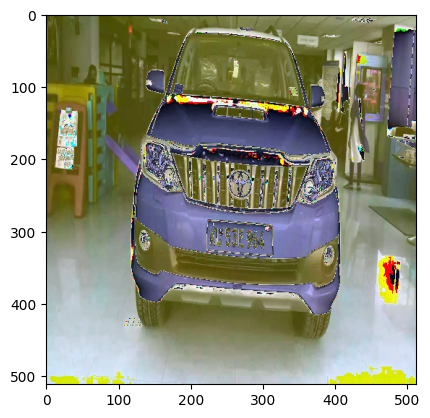

[222.4128, 284.0398293029872, 314.9824, 335.74964438122333]

In [ ]:
img , target , label = val_set[59]
img = TF.to_pil_image(img)
plt.imshow(img)
plt.show()
target

In [ ]:
train_loader = DataLoader(train_set,batch_size= 1,
                          shuffle=True #, #num_workers =3
                          )

val_loader = DataLoader(val_set, batch_size= 1 ,shuffle=False ,
)


test_loader = DataLoader(test_set, batch_size= 1 ,shuffle=False ,
                        )

In [ ]:
#pip install ultralytics

In [ ]:
#from ultralytics import YOLO

In [ ]:
#model = YOLO("yolov8m.pt")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained= True)

In [ ]:
ftrs = model.roi_heads.box_predictor.cls_score.in_features

In [ ]:
model.roi_heads.box_predictor= FastRCNNPredictor(ftrs , 2)

In [ ]:
def loss_fn(pred , target):
    #localization_loss = nn.MSELoss()
    loss = nn.MSELoss()(pred ,target)
    return loss


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = model.to(device)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/numberplatemodel2.pth" , map_location="cpu"))

<All keys matched successfully>

In [ ]:
opt = torch.optim.Adam(model.parameters() , lr = 1e-5, weight_decay = 1e-3)

In [ ]:
model = model.to(device)


In [ ]:
def train_line(model , img , box, label, opt ):
  model.train();
  device = "cuda"
  model = model.to(device)
  img = img.to(device)
  box = box.to(device)
  box = box.unsqueeze(0)
  label = label.to(device)

  target =  [{"boxes" : box , "labels":label}for labell in label ]
  loss = model(img, target)
  loss = sum(loss for loss in loss.values())
  #loss = loss_fn(pred , box)
  opt.zero_grad()
  loss.backward()
  opt.step()


In [ ]:
for num_epoch in range(50):
    for img_train , box_train , label_train in train_loader:
        model.train();
        box_train = torch.tensor(box_train)
        img_train = img_train.to(device)
        box_train = box_train.to(device)
        label_train = label_train.to(device)

        train_line(model , img_train , box_train , label_train ,  opt)

    with torch.no_grad():
        loss_list = []
        print("============================Epoch: " , num_epoch)
        imgcount = 0
        for img_val , box_val , label_val in val_loader:
            model.eval();
            box_val = torch.tensor(box_val)
            img_val = img_val.to(device)
            box_val = box_val.to(device)
            label_val = label_val.to(device)
            pred = model(img_val)
            box_pred =   pred[0]["boxes"]
            val_loss = loss_fn(box_pred, box_val)

            if  0 / val_loss  != 0:
                imgcount +=1
            else:
                loss_list.append(val_loss)
                imgcount +=1
            print("===========image:" , {"img_count" : imgcount, "loss": val_loss})
        avg_loss = sum(loss_list) / len(loss_list)
        print("avg_val_loss: " , avg_loss)





            #print("score:" , score)

            #label = pred[0]["labels"]
            #print("labels", label)


============================Epoch:  0
===========image: {'img_count': 1, 'loss': tensor(770.7745, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 2, 'loss': tensor(20014.7114, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 3, 'loss': tensor(50600.3982, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 4, 'loss': tensor(255.8255, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 5, 'loss': tensor(37143.6244, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 6, 'loss': tensor(16.2601, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 7, 'loss': tensor(35108.4652, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 8, 'loss': tensor(1.5161, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 9, 'loss': tensor(1.1709, device='cuda:0', dtype=torch.float64)}
===========image: {'img_count': 10, 'loss': tensor(32511.5839, devic

In [ ]:
#torch.save(model.state_dict() , "/content/drive/MyDrive/numberplatemodel2.pth")

In [ ]:
from matplotlib import image as im

In [ ]:
imagetest = im.imread("/content/drive/MyDrive/cars-5334232_1280.jpg") #testing outsourced image

In [ ]:
transform = transforms.Compose([transforms.ToTensor() , transforms.Resize((512 , 512)), transforms.Normalize([0.5,0.5,0.5] , [0.5,0.5,0.5])])

In [ ]:
imagetest = transform(imagetest)

<All keys matched successfully>

In [ ]:
img , target , label = test_set[12]
devicee = "cpu"
model = model.to(devicee)
model.eval()
prediction = model(imagetest.unsqueeze(0))   #edit imagetest to img to use image from testset
print(prediction)

[{'boxes': tensor([[369.6364, 308.6528, 397.0346, 331.5377],
        [226.1772,  96.8532, 281.0851, 132.4695],
        [371.6479, 213.4139, 399.7896, 229.5106]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9826, 0.7661, 0.2390], grad_fn=<IndexBackward0>)}]


In [ ]:
boxes= prediction[0]["boxes"]
scores = prediction[0]['scores']
#labels = prediction[0]['labels']


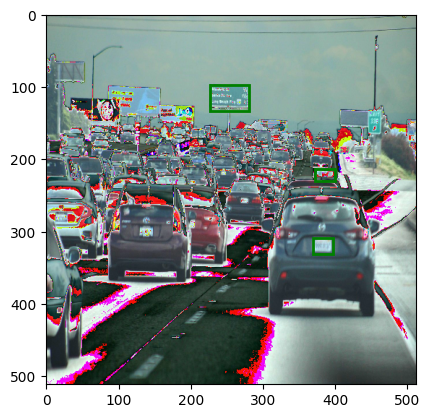

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
transform = T.ToPILImage()
image =  transform(imagetest)
fig, ax = plt.subplots(1)
ax.imshow(image)
for box in boxes:
      xmin, ymin, xmax, ymax = box.tolist()
      rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='green', linewidth=2)
      ax.add_patch(rect)

plt.imshow(image )

In [ ]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    union_area = float(boxA_area + boxB_area - intersection_area)

    iou = intersection_area / union_area
    return iou





In [ ]:
f1_score_list = []
idx = 0
while idx < 31:
    img , bbox ,label  = test_set[idx]
    model.eval();
    pred = model(img.unsqueeze(0))
    idx+=1
    f1_score = calculate_iou(pred[0]["boxes"][:1].tolist()[0], bbox)
    f1_score_list.append(f1_score)

avg_score = sum(f1_score_list) / len(f1_score_list)
print(avg_score)



0.821796442854501
